# Homework 4 - Jingwen Li

## FINM 35700 - Spring 2023

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on multiple files (from previous weeks):

- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the corporate bonds symbology file `corp_symbology`,
- the cash bond market data file `market_prices_eod`,
- the CDS data file `cds_market_data_eod`. 
- the SOFR OIS Swap symbology file `sofr_swap_symbology`,
- the SOFR OIS Swap market data file `sofr_swaps_market_data_eod`.



In [108]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Collection of useful helper functions from previous homeworks

In [109]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")


def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    # Create maturity from details['maturity']
    maturity = get_ql_date(details['maturity'])
    
    # Create acc_first from details['acc_first']
    acc_first = get_ql_date(details['acc_first'])
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    period = ql.Period(2)
    
    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule


def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporates use ql.Thirty360(ql.Thirty360.USA)
    if details['dcc'] == '30/360':
        day_count = ql.Thirty360(ql.Thirty360.USA)
    elif details['dcc'] == 'ACT/ACT':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    else:
        raise ValueError(f"unsupported day count, {type(details['dcc'])}, {details['dcc']}")
    
    # Create day_count from details['start_date']    
    issue_date = get_ql_date(details['start_date'])
    
    # Create days_settle from details['days_settle']
    days_settle = int(float(details['days_settle']))

    # Create days_settle from details['coupon']
    coupon = float(details['coupon'])/100.

    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond


def get_bond_cashflows(bond: ql.FixedRateBond, calc_date=ql.Date):
    '''Returns all future cashflows as of calc_date, i.e. with payment dates > calc_date.
    '''    
    day_counter = bond.dayCounter()    
    
    x = [(cf.date(), day_counter.yearFraction(calc_date, cf.date()), cf.amount()) for cf in bond.cashflows()]
    cf_date, cf_yearFrac, cf_amount = zip(*x)
    cashflows_df = pd.DataFrame(data={'CashFlowDate': cf_date, 'CashFlowYearFrac': cf_yearFrac, 'CashFlowAmount': cf_amount})

    # filter for payment dates > calc_date
    cashflows_df = cashflows_df[cashflows_df.CashFlowYearFrac > 0]
    return cashflows_df


def calibrate_yield_curve_from_frame(
        calc_date: ql.Date,
        treasury_details: pd.DataFrame,
        price_quote_column: str):
    '''Create a calibrated yield curve from a details dataframe which includes bid/ask/mid price quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = treasury_details.sort_values(by='maturity')    
    
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    day_count = ql.ActualActual(ql.ActualActual.ISMA)

    bond_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        bond_object = create_bond_from_symbology(row)
        
        tsy_clean_price_quote = row[price_quote_column]
        tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))
        
        bond_helper = ql.BondHelper(tsy_clean_price_handle, bond_object)
        bond_helpers.append(bond_helper)
        
    yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helpers, day_count)
    yield_curve.enableExtrapolation()
    return yield_curve


def calibrate_sofr_curve_from_frame(
        calc_date: ql.Date,
        sofr_details: pd.DataFrame,
        rate_quote_column: str):
    '''Create a calibrated yield curve from a SOFR details dataframe which includes rate quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = sofr_details.sort_values(by='tenor')    
    
    # settle_days
    settle_days = 2
    
    # For US SOFR OIS Swaps 
    day_count = ql.Actual360()

    # For US SOFR Swaps     
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    sofr_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        sofr_quote = row[rate_quote_column]
        tenor_in_years = row['tenor']
        sofr_tenor = ql.Period(tenor_in_years, ql.Years)
        
        # create sofr_rate_helper
        sofr_helper = ql.OISRateHelper(settle_days, sofr_tenor, ql.QuoteHandle(ql.SimpleQuote(sofr_quote/100)), ql.Sofr())
                        
        sofr_helpers.append(sofr_helper)
        
    sofr_yield_curve = ql.PiecewiseLinearZero(settle_days, calendar, sofr_helpers, day_count)
    sofr_yield_curve.enableExtrapolation()
    
    return sofr_yield_curve


# Problem 1: Pricing risky bonds in the hazard rate model
## This is building upon
- Homework 2 "Problem 2: US Treasury yield curve calibration (On-The-Runs)",
- Homework 3 "Problem 3: US SOFR swap curve calibration" and
- Homework 3 "Problem 4: CDS Hazard Rate calibration".

## a. Prepare the market data
### Load the symbology + market data dataframes. Calibrate the following curves as of 2023-04-14:
- the "on-the-run" US Treasury curve,
- the US SOFR curve and 
- the IBM CDS hazard rate curve (on the top of SOFR discount curve).


In [110]:
govt_otr = pd.read_excel("../data/govt_on_the_run.xlsx")
govt_sym = pd.read_excel("../data/govt_symbology.xlsx")
corp_sym = pd.read_excel("../data/corp_symbology.xlsx")
sofr_market = pd.read_excel("../data/sofr_swaps_market_data_eod.xlsx")
sofr_sym = pd.read_excel("../data/sofr_swaps_symbology.xlsx")
cds = pd.read_excel("../data/cds_market_data_eod.xlsx")
market_price = pd.read_excel("../data/market_prices_eod.xlsx")

In [111]:
def create_ts_otr(govt_sym, corp_sym):
    govt_corp_sym = pd.concat([govt_sym, corp_sym], ignore_index=True)
    govt_corp_sym = govt_corp_sym[govt_corp_sym['cpn_type'] == 'FIXED']
    govt_corp_sym.reset_index(drop=True, inplace=True)
    tenors = ['2', '3', '5', '7', '10', '20', '30']
    matching = '|'.join([f'GT{tenor} Govt' for tenor in tenors])
    treasury_otr = govt_otr[govt_otr['ticker'].str.contains(matching)]
    merged_data = govt_corp_sym.merge(market_price, on=['isin', 'figi'], how='inner', suffixes=('', '_y'))
    treasury_otr_df = merged_data[merged_data['isin'].isin(treasury_otr['isin'])]
    treasury_otr_df['mid'] = (treasury_otr_df['bid'] + treasury_otr_df['ask'])/2
    treasury_otr_df['mid_yield'] = (treasury_otr_df['bid_yield'] + treasury_otr_df['ask_yield'])/2
    treasury_otr_df['term'] = (treasury_otr_df['maturity'] - treasury_otr_df['start_date']).dt.days / 365.25
    treasury_otr_df['TTM'] = (treasury_otr_df['maturity'] - pd.Timestamp('2023-04-14')).dt.days / 365.25
    return  treasury_otr_df

In [112]:
def create_sofr_df(sofr_sym,sofr_market):
    sofr_details = pd.DataFrame(columns = ['figi','tenor','rate_quote'])
    sofr_details[['figi','tenor']] = sofr_sym[['figi','term']] 
    sofr_details = sofr_details.set_index('figi')
    sofr_swap_symbology = sofr_market.reset_index()
    sofr_swap_symbology = sofr_swap_symbology.set_index('date')
    sofr_swap_symb = sofr_swap_symbology.loc['2023-04-28']

    for i in sofr_details.index:
        sofr_details.loc[i,'mid_rate'] = sofr_swap_symb.loc[sofr_swap_symb['symbol'] == i,'mid_rate'].values[0]
    return sofr_details

In [113]:
def create_hazard_rate_curve(sofr_yield_curve, calc_date, CDS_recovery_rate, settle_days):

    CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
                
    # CDS spreads for IBM as of calc_date = 2023-04-14
    CDS_spreads = [17.25, 24.09, 35.44, 55.58, 72.52, 79.92]

    sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)

    CDS_helpers = [ql.SpreadCdsHelper((CDS_spread / 10000.0), CDS_tenor, settle_days, ql.TARGET(),
                                    ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, ql.Actual360(), CDS_recovery_rate, sofr_yield_curve_handle)
    for (CDS_spread, CDS_tenor) in zip(CDS_spreads, CDS_tenors)]

    # bootstrap hazard_rate_curve
    hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, ql.Actual360())

    return hazard_rate_curve

In [114]:
# Use static calculation/valuation date of 2023-04-14, matching data available in the market prices EOD file
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date



# tsy_yield_curve calibration
# TODO: Follow Homework 2 Problem 2 and populate the US Treasury on-the-run symbology + market data frame !!!
treasury_otr_df = create_ts_otr(govt_sym, corp_sym)
tsy_yield_curve = calibrate_yield_curve_from_frame(calc_date, treasury_otr_df, 'mid_clean')
tsy_yield_curve_handle = ql.YieldTermStructureHandle(tsy_yield_curve)


# sofr_yield_curve calibration
sofr_df = create_sofr_df(sofr_sym, sofr_market)   # TODO: Follow Homework 3 Problem 3 and populate the SOFR symbology + market data frame !!!
sofr_yield_curve = calibrate_sofr_curve_from_frame(calc_date, sofr_df, 'mid_rate')
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)


# hazard_rate_curve calibrated to IBM CDS par spreads
# bootstrap hazard_rate_curve
CDS_recovery_rate, settle_days = 0.4, 2

hazard_rate_curve = create_hazard_rate_curve(sofr_yield_curve, calc_date,CDS_recovery_rate, settle_days )  # TODO: Follow Homework 3 Problem 4 and create the IBM hazard rate curve !!!
default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)

## b. Create the IBM risky bond objects
### Identify the following 3 IBM fixed rate bonds in the symbology table and create the corresponding fixed rate bonds (3 bond objects).

- security = 'IBM 3.3 05/15/26' / figi = 'BBG00P3BLH05'
- security = 'IBM 3.3 01/27/27' / figi = 'BBG00FVNGFP3'
- security = 'IBM 3 1/2 05/15/29' / figi = 'BBG00P3BLH14'

Use the create_bond_from_symbology() function (discussed in from Homework 2, Problem 1b) to create the bonds objects.

List the bond cashflows using the get_bond_cashflows() function.



In [115]:
isins = ['BBG00P3BLH05','BBG00FVNGFP3','BBG00P3BLH14']
filtered_rows = corp_sym[corp_sym['figi'].isin(isins)]

bond_objs = {}

for i, row in filtered_rows.iterrows():
    bond_details = row.to_dict()
    bond = create_bond_from_symbology(bond_details)
    bond_objs[bond_details['isin']] = bond

In [116]:
print('Cash flows of the IBM risky bonds:')
# Iterate over the cash flows and display relevant information
for key, bond_obj in bond_objs.items():
    print(f"Bond Key: {key}")
    cashflows = bond_obj.cashflows()

    for cashflow in cashflows:
        date = cashflow.date().ISO()
        amount = cashflow.amount()
        print("Date: {}, Amount: {}".format(date, amount))

Cash flows of the IBM risky bonds:
Bond Key: US459200JR30
Date: 2017-07-27, Amount: 1.649999999999996
Date: 2018-01-27, Amount: 1.649999999999996
Date: 2018-07-27, Amount: 1.649999999999996
Date: 2019-01-27, Amount: 1.649999999999996
Date: 2019-07-27, Amount: 1.649999999999996
Date: 2020-01-27, Amount: 1.649999999999996
Date: 2020-07-27, Amount: 1.649999999999996
Date: 2021-01-27, Amount: 1.649999999999996
Date: 2021-07-27, Amount: 1.649999999999996
Date: 2022-01-27, Amount: 1.649999999999996
Date: 2022-07-27, Amount: 1.649999999999996
Date: 2023-01-27, Amount: 1.649999999999996
Date: 2023-07-27, Amount: 1.649999999999996
Date: 2024-01-27, Amount: 1.649999999999996
Date: 2024-07-27, Amount: 1.649999999999996
Date: 2025-01-27, Amount: 1.649999999999996
Date: 2025-07-27, Amount: 1.649999999999996
Date: 2026-01-27, Amount: 1.649999999999996
Date: 2026-07-27, Amount: 1.649999999999996
Date: 2027-01-27, Amount: 1.649999999999996
Date: 2027-01-27, Amount: 100.0
Bond Key: US459200JZ55
Date: 2

## c. Compute CDS-implied (intrinsic) prices for the IBM fixd rate bonds

Price the 3 IBM bonds using the CDS-calibrated hazard rate curve for IBM (via RiskyBondEngine).

Print the clean prices and yields for the 3 test bonds. You can use the example code below.


In [117]:
flat_recovery_rate = 0.40

fixed_rate_bond = bond_objs['US459200JZ55']   # TODO: Pick one of the 3 IBM test bonds !!!

# Risky bond engine uses the calibrated CDS hazard rate curve for pricing credit default risk 
risky_bond_engine = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle)

fixed_rate_bond.setPricingEngine(risky_bond_engine)

corpBondModelPrice = fixed_rate_bond.cleanPrice()

corpBondModelYield = fixed_rate_bond.bondYield(corpBondModelPrice, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100

print('corpBondCleanPrice', corpBondModelPrice)
print('corpBondYield', corpBondModelYield)


corpBondCleanPrice 97.4943188134848
corpBondYield 4.175997972488404


## d. Compute the "intrinsic" vs market price basis for the IBM bonds

Load the market clean prices and yields (mid quotes) from the market quotes dataframe as of 2023-04-14. Compute the basis between the "CDS-implied intrinsic" vs market values. 

- BasisInPrice = corpBondModelPrice - corpBondMarketPrice
- BasisInYield = corpBondModelYield - corpBondMarketYield


Are the CDS intrinsic prices lower or higher than the bond prices observed on the market? What factors could explain the basis?


In [118]:
market_price = market_price.set_index('isin')
market_price['mid_yield'] = (market_price['bid_yield'] + market_price['ask_yield']) * 0.5

In [119]:
BasisInPrice, BasisInYield = {}, {}
for key, bond_obj in bond_objs.items():
    risky_bond_engine = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle)
    corpBondMarketPrice = market_price.loc[key,'mid_clean']
    corpBondMarketYield = market_price.loc[key,'mid_yield']
    bond_obj.setPricingEngine(risky_bond_engine)
    corpBondModelPrice = bond_obj.cleanPrice()
    corpBondModelYield = bond_obj.bondYield(corpBondModelPrice, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100
    BasisInPrice[key] = corpBondModelPrice - corpBondMarketPrice
    BasisInYield[key] = corpBondModelYield - corpBondMarketYield

In [120]:
basis = pd.DataFrame()
for name, data in [('BasisInPrice', BasisInPrice), ('BasisInYield', BasisInYield)]:
    temp_df = pd.DataFrame.from_dict(data, orient='index', columns=[name])
    basis = basis.merge(temp_df, how='outer', left_index=True, right_index=True)
# Rename the index name
basis.index.name = 'Bonds'

In [121]:
basis

,BasisInPrice,BasisInYield
Bonds,,
US459200JR30,0.641018,-0.189970
US459200JZ55,0.707319,-0.252002
US459200KA85,2.255055,-0.440099


# Problem 2: Compute scenario sensitivities for risky bonds
## a. Compute scenario IR01s for the 3 IBM bonds
Use the 3 IBM test bonds defined in Problem 1. 

Compute the scenario IR01 and Durations using a -1bp interest rate shock, as described in Section 6. "Market Data Scenarios" in the QuantLib introductory notebook.

Remember that DV01 = Dirty_Price * Duration.


In [122]:
# Set the static valuation date
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

# using 5% flat interest rate for testing
flat_rate = ql.SimpleQuote(0.05)
rate_handle = ql.QuoteHandle(flat_rate)
day_count = ql.Actual360()
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
continuous_comp = ql.Continuous # continously compounded rate of 5%
flat_yield_curve = ql.FlatForward(calc_date, rate_handle, day_count, continuous_comp)
flat_yield_curve_handle = ql.YieldTermStructureHandle(flat_yield_curve)

In [123]:
# start with interest_rate_bump = 0
interest_rate_bump = ql.SimpleQuote(0.0)
flat_yield_curve_bumped = ql.ZeroSpreadedTermStructure(flat_yield_curve_handle, ql.QuoteHandle(interest_rate_bump))

bond_engine = ql.DiscountingBondEngine(ql.YieldTermStructureHandle(flat_yield_curve_bumped))

results = pd.DataFrame(columns = [['US459200JR30','US459200JZ55','US459200KA85']], \
                       index = [['Price_base_case', 'Price_up_onebps_scenario', 'Price_diff_up_onebps_scenario',\
        'Price_down_onebps_scenario', 'Price_diff_down_onebps_scenario','DV01','Duration','gamma_1bp','convexity']])

for key, fixed_rate_bond in bond_objs.items():
    
    fixed_rate_bond.setPricingEngine(bond_engine)
    price_base = fixed_rate_bond.cleanPrice()

    # Original price (zero interest rate bump)
    Price_base_case = round(price_base, 4)

    # Bump interest rate by +1bps (parallel shift)
    interest_rate_bump.setValue(0.0001)
    price_up_1bp = fixed_rate_bond.cleanPrice()
    Price_up_onebps_scenario = round(price_up_1bp, 4)
    Price_diff_up_onebps_scenario = round(price_up_1bp - price_base, 6)

    # Bump interest rate by -1bps (parallel shift)
    interest_rate_bump.setValue(-0.0001)
    price_down_1bp = fixed_rate_bond.cleanPrice()
    Price_down_onebps_scenario = round(price_down_1bp, 4)
    Price_diff_down_onebps_scenario = round(price_down_1bp - price_base, 6)
    
    # Duration, DV01, Convexity
    dv01 = round((price_down_1bp - Price_base_case) * 1e4 / 100, 4)
    duration = round(dv01 / fixed_rate_bond.dirtyPrice() * 100, 4)
    gamma_1bp = (price_down_1bp - 2*Price_base_case + price_up_1bp) * 1e8 / 100
    convexity = round(gamma_1bp / fixed_rate_bond.dirtyPrice() * 100, 4)

    # Remove interest rate bump
    interest_rate_bump.setValue(0)
    values = [Price_base_case, Price_up_onebps_scenario, Price_diff_up_onebps_scenario,\
            Price_down_onebps_scenario, Price_diff_down_onebps_scenario,dv01,duration,gamma_1bp,convexity]
    results[key] = values

In [124]:
results

,US459200JR30,US459200JZ55,US459200KA85
Price_base_case,93.746200,94.831700,91.540000
Price_up_onebps_scenario,93.712100,94.803400,91.488900
Price_diff_up_onebps_scenario,-0.034014,-0.028338,-0.051027
Price_down_onebps_scenario,93.780200,94.860100,91.591000
Price_diff_down_onebps_scenario,0.034026,0.028347,0.051057
DV01,3.398200,2.838100,5.101900
Duration,3.595100,2.948300,5.481300
gamma_1bp,-76.448412,77.299717,-45.874074
convexity,-80.878400,80.300900,-49.285400


## b. Compute scenario Convexities for the 3 IBM bonds
Use the 3 IBM test bonds defined in Problem 1. 

Compute the scenario Convexities using the +/-1bp interest rate shocks, as described in Section 6. "Market Data Scenarios" in the QuantLib introductory notebook.


In [125]:
results.loc['convexity']

,US459200JR30,US459200JZ55,US459200KA85
convexity,-80.8784,80.3009,-49.2854


## c. Compute scenario HR01s (hazard rate sensitivity) and CS01s (credit spread sensitivity) for the 3 IBM bonds
Use the 3 IBM test bonds defined in Problem 1. 

Apply a -1bp (parallel shift) scenario to the IBM CDS Par Spread quotes and calibrate the scenario hazard rate curve. 

Create a new scenario RiskyBondEngine, using the scenario hazard rate curve.

Reprice the risky bonds on the scenario RiskyBondEngine (using the bumped hazard rate curve) to obtain the -1bp scenario HR01 (hazard rate sensitivity).

The credit spread sensitivity CS01 is defined as CS01 = (ScenarioPrice - BasePrice) / (ScenarioYield - BasePYield) * 100.

Compute the scenario bond yields and the scenario CS01s for the 3 bonds.


In [126]:
cds = cds.set_index('date')
cds.loc['2023-04-14']

ticker                                       IBM
short_name              Intl Business Machs Corp
tier                                      SNRFOR
sector                                Technology
region                                    N.Amer
currency                                     USD
doc_clause                                  XR14
running_coupon                              0.01
cds_assumed_recovery                         0.4
par_spread_1y                           0.001725
par_spread_2y                           0.002409
par_spread_3y                           0.003544
par_spread_5y                           0.005558
par_spread_7y                           0.007252
par_spread_10y                          0.007992
Name: 2023-04-14 00:00:00, dtype: object

In [151]:
CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]

CDS_spreads = [17.25, 24.09, 35.44, 55.58, 72.52, 79.92]

CDS_spreads_01  = [x - 1 for x in CDS_spreads]

CDS_helpers = [ql.SpreadCdsHelper((CDS_spreads_01 / 10000.0), CDS_tenor, settle_days, ql.TARGET(),
                                ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, ql.Actual360(), CDS_recovery_rate, sofr_yield_curve_handle)
for (CDS_spreads_01, CDS_tenor) in zip(CDS_spreads, CDS_tenors)]

In [152]:
results_risky_bonds = pd.DataFrame(columns=['US459200JR30', 'US459200JZ55', 'US459200KA85'],
                                   index=['Base_Price','Base_Yield','ScenarioPrice', 'ScenarioYield', 'HR01', 'CS01'])

for key, risky_bond in bond_objs.items():
    risky_bond.setPricingEngine(bond_engine)

    # Base price and yield
    hazard_rate_bump = ql.SimpleQuote(0.0)
    base_price = risky_bond.cleanPrice()
    base_yield = risky_bond.bondYield(base_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual)
    
    # Bump hazard rate by -1bps (parallel shift)
    hazard_rate_bump.setValue(-0.0001)
    
    hazard_rate_curve_01 = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, ql.Actual360())
    hazard_rate_curve_01.enableExtrapolation()
    default_prob_curve_handle01 = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve_01)

    # Create the RiskyBondEngine with the bumped hazard rate curve
    risky_bond_engine = ql.RiskyBondEngine(default_prob_curve_handle01, flat_recovery_rate, tsy_yield_curve_handle)

    # Set the pricing engine for the bond
    risky_bond.setPricingEngine(risky_bond_engine)
    
    scenario_price = risky_bond.cleanPrice()
    scenario_yield = risky_bond.bondYield(scenario_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual)

    # Compute HR01 and CS01
    hr01 = round(base_price - scenario_price, 6)
    cs01 = round((scenario_price - base_price) / ((scenario_yield+1) - base_yield) * 100, 6)

    # Remove hazard rate bump
    hazard_rate_bump.setValue(0)

    results_risky_bonds[key] = [base_price, base_yield, scenario_price, scenario_yield, hr01, cs01]

In [153]:
results_risky_bonds

,US459200JR30,US459200JZ55,US459200KA85
Base_Price,93.746155,94.831734,91.539962
Base_Yield,0.051423,0.051375,0.051384
ScenarioPrice,96.911018,97.494319,96.227055
ScenarioYield,0.041920,0.041760,0.042099
HR01,-3.164863,-2.662585,-4.687093
CS01,319.522473,268.843359,473.101893


## d. Compute scenario Rec01 (recovery rate sensitivity) for the 3 IBM bonds
Use the 3 IBM test bonds defined in Problem 1. 

Apply a +1% scenario bump to the IBM recovery rate (flat_recovery_rate parameter will move from 40% to 41%).

Create a new scenario RiskyBondEngine, using the scenario new recovery rate.

Reprice the risky bonds on the scenario RiskyBondEngine (using the bumped recovery rate) to obtain the +1% scenario REC01 (recovery rate sensitivity).


In [166]:
results_cds_bonds = pd.DataFrame(columns=['US459200JR30', 'US459200JZ55', 'US459200KA85'],
                                index=['Base_Price', 'Base_Yield', 'ScenarioPrice', 'ScenarioYield', 'REC01'])

for key, cds_bond in bond_objs.items():
    cds_bond.setPricingEngine(bond_engine)

    # Base price and yield
    hazard_rate_bump = ql.SimpleQuote(0.0)
    base_price = cds_bond.cleanPrice()
    base_yield = cds_bond.bondYield(base_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual)
    
    # Bump recovery rate by +1%
    bumped_recovery_rate = CDS_recovery_rate + 0.01
    
    # Recreate the CDS hazard rate curve with bumped recovery rate
    bumpedCDS_hazard_rate_curve = create_hazard_rate_curve(sofr_yield_curve, calc_date, bumped_recovery_rate, settle_days)
    bumpedCDS_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(bumpedCDS_hazard_rate_curve)
    
    # Create a new RiskyBondEngine with bumped recovery rate
    cds_engine = ql.RiskyBondEngine(bumpedCDS_prob_curve_handle, bumped_recovery_rate, tsy_yield_curve_handle)

    # Set the pricing engine for the bond
    cds_bond.setPricingEngine(cds_engine)
    
    # Calculate scenario price and yield
    scenario_price = cds_bond.cleanPrice()
    scenario_yield = cds_bond.bondYield(scenario_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual)

    # Calculate recovery rate sensitivity
    REC01 = round((scenario_price - base_price)/0.01, 6)

    results_cds_bonds[key] = [base_price, base_yield, scenario_price, scenario_yield, REC01]

In [167]:
results_cds_bonds

,US459200JR30,US459200JZ55,US459200KA85
Base_Price,93.746155,94.831734,91.539962
Base_Yield,0.051423,0.051375,0.051384
ScenarioPrice,96.911053,97.494280,96.227136
ScenarioYield,0.041920,0.041760,0.042099
REC01,316.489732,266.254617,468.717435


# Problem 3: Nelson-Siegel model for smooth hazard rate curves
## Follow Lecture 4, Section 1 "Parametric Hazard Rate Models"
## Follow Section "13. Smooth parametric yield and hazard rate curves: the Nelson-Siegel model" in the QuantLib Intro V3 notebook
## You can also take a look at Dr. Mark Hendricks Fixed Income notebooks describing the Nelson-Siegel model calibration on US Treasuries (GitHub repo link posted in Canvas).

## a. Prepare the market data as of 2023-04-14
Load the symbology + market data dataframes for all Verizon fixed rate bonds (ticker = 'VZ'). 

Calibrate the "on-the-run" US Treasury curve, which will be used as discount factor curve.


In [28]:
market_price_VZ = market_price[market_price['ticker'] == 'VZ']
corp_symb_VZ = corp_sym[corp_sym['ticker'] == 'VZ']
symb_VZ = market_price_VZ.merge(corp_symb_VZ, on='isin')

In [29]:
symb_VZ

,isin,date,class_x,ticker_x,figi_x,bid,ask,mid_clean,mid_dirty,bid_yield,...,cpn_freq,days_settle,start_date,cpn_first,acc_first,maturity,mty_typ,rank,country,currency
0,US92343VAF13,2023-04-14,Corp,VZ,BBG00000BHR9,106.514,107.703,107.109,107.404,5.572,...,2,2,2007-04-03,2007-10-01,2007-04-03,2037-04-01,AT MATURITY,Sr Unsecured,US,USD
1,US92343VAK08,2023-04-14,Corp,VZ,BBG0000M1DD6,106.596,107.916,107.256,108.376,5.733,...,2,2,2008-02-12,2008-08-15,2008-02-12,2038-02-15,AT MATURITY,Sr Unsecured,US,USD
2,US92343VBE39,2023-04-14,Corp,VZ,BBG0027BCJ08,95.437,96.445,95.941,98.144,5.134,...,2,2,2011-11-03,2012-05-01,2011-11-03,2041-11-01,AT MATURITY,Sr Unsecured,US,USD
3,US92343VBG86,2023-04-14,Corp,VZ,BBG003LZSS91,82.472,83.385,82.929,84.715,5.301,...,2,2,2012-11-07,2013-05-01,2012-11-07,2042-11-01,CALLABLE,Sr Unsecured,US,USD
4,US92343VBS25,2023-04-14,Corp,VZ,BBG00580D503,110.109,110.490,110.300,110.886,5.133,...,2,2,2013-09-18,2014-03-15,2013-09-18,2033-09-15,AT MATURITY,Sr Unsecured,US,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,US92346MJT99,2023-04-14,Corp,VZ,BBG017BR3G75,95.239,96.343,95.791,97.555,5.070,...,2,2,2022-05-19,2022-11-15,2022-05-19,2029-05-15,CALLABLE,Sr Unsecured,US,USD
80,US92346MJZ59,2023-04-14,Corp,VZ,BBG017QYK9Z0,86.782,89.207,87.994,89.583,5.572,...,2,2,2022-06-03,2022-12-15,2022-06-03,2052-06-15,CALLABLE,Sr Unsecured,US,USD
81,US92346MKG59,2023-04-14,Corp,VZ,BBG0191HMXJ3,86.528,88.973,87.750,88.555,5.533,...,2,2,2022-08-11,2023-02-15,2022-08-11,2052-08-15,CALLABLE,Sr Unsecured,US,USD
82,US92346MKQ32,2023-04-14,Corp,VZ,BBG019LXC9P3,97.806,99.074,98.440,98.852,4.902,...,2,2,2022-09-22,2023-03-15,2022-09-22,2029-09-15,CALLABLE,Sr Unsecured,US,USD


In [30]:
tsy_yield_curve

<QuantLib.QuantLib.PiecewiseLogCubicDiscount; proxy of <Swig Object of type 'ext::shared_ptr< PiecewiseLogCubicDiscount > *' at 0x169b018d0> >

## b. Create the Nelson-Siegel curve shape (4 parameters) and compute the corresponding SSE function.
For a given set of parameters, write a function to compute the SSE "Sum of Squared Errors" penalty function in price space (defined as sum of squared differences between model and market prices for all Verizon fixed-rate bonds).


For each bond, compute the bond durations, using Section "9. Analytical Duration" in the QuantLib introductory notebook as a template.

Use 1/Duration as SSE weights. You can ignore the liquidity adjuster for the purpose of this exercise.

In [36]:
def nelson_siegel(params, maturity):
    ''' params = (theta1, theta2, theta3, lambda)'''    
    slope_1 = (1 - np.exp(-maturity/params[3]))/(maturity/params[3])

    if(np.isnan(slope_1)):
        slope_1 = 1

    curvature_1 = slope_1 - np.exp(-maturity/params[3])

    total_value = params[0] + params[1] * slope_1 + params[2] * curvature_1
    
    return total_value

def nelson_siegel_extended(params, maturity):
    
    slope_1 = (1 - np.exp(-maturity/params[3]))/(maturity/params[3])

    if(np.isnan(slope_1)):
        slope_1 = 1

    curvature_1 = slope_1 - np.exp(-maturity/params[3])

    total_value = params[0] + params[1] * slope_1 + params[2] * curvature_1
    
    if(params[5] != 0):
        slope_2 = (1 - np.exp(-maturity/params[5]))/(maturity/params[5])

        if(np.isnan(slope_2)):
            slope_2 = 1

        curvature_2 = slope_2 - np.exp(-maturity/params[5])

        total_value = total_value + params[4] * curvature_2
        
    
    return total_value

In [32]:
def compute_sse_weight(df):

    df['duration'] = 0.0
    df['sse_weight'] = 0.0

    day_count = ql.Actual360()
    compounding = ql.Compounded
    coupon_freq = ql.Semiannual

    for index, row in df.iterrows():
        
        bond_object = create_bond_from_symbology(row)

        bond_yield = df['mid_yield'][index]
        bond_yield_rate = ql.InterestRate(bond_yield/100, day_count, compounding, coupon_freq)

        bond_duration = ql.BondFunctions.duration(bond_object, bond_yield_rate)

        df['duration'][index] = bond_duration
        df['sse_weight'][index] = 1/bond_duration

    return df

In [33]:
def compute_sse(nelson_siegel_params, df, calc_date):

    nelson_siegel_surv_prob_dates = [calc_date + ql.Period(T , ql.Years) for T in range(31)]
    nelson_siegel_average_hazard_rates = [nelson_siegel(nelson_siegel_params, T) for T in range(31)]
    nelson_siegel_surv_prob_levels = [np.exp(-T * nelson_siegel_average_hazard_rates[T]) for T in range(31)]

    nelson_siegel_credit_curve = ql.SurvivalProbabilityCurve(nelson_siegel_surv_prob_dates, \
        nelson_siegel_surv_prob_levels, ql.Actual360(), ql.TARGET())
    nelson_siegel_credit_curve.enableExtrapolation()
    nelson_siegel_credit_curve_handle = ql.DefaultProbabilityTermStructureHandle(nelson_siegel_credit_curve)

    bond_recovery_rate = 0.4

    nelson_siegel_risky_bond_engine = ql.RiskyBondEngine(nelson_siegel_credit_curve_handle, bond_recovery_rate, flat_yield_curve_handle)

    sse = 0.0

    for index, row in df.iterrows():
        
        bond_object = create_bond_from_symbology(row)
        bond_object.setPricingEngine(nelson_siegel_risky_bond_engine)

        error = ((bond_object.cleanPrice() - df['mid_clean'][index])**2)* df['sse_weight'][index]
        sse += error
    
    return sse

In [34]:
df_verizon = compute_sse_weight(symb_VZ)

In [37]:
nelson_siegel_params = [0.0300, -0.0100, -0.0010, 2]
compute_sse(nelson_siegel_params, df_verizon, calc_date)

894.9160173900767

## c. Calibrate the Nelson-Siegel model parameters to obtain the smooth Verizon credit curve.

Minimize the SSE (pricing error) function to obtain the optimal/calibrated Nelson-Siegel parameter vector. 

Create the calibrated/smooth credit curve corresponding to the optimal model parameters.

In [38]:
theta0_list = [0.02]
theta1_list = list(np.linspace(-0.02, -0.015, 10))
theta2_list = list(np.linspace(-0.02, -0.007, 10))
lamb_list = list(np.linspace(4.5, 5, 10))

params_list = []
sse_list = []

for theta0 in theta0_list:
    for theta1 in theta1_list:
        for theta2 in theta2_list:
            for lamb in lamb_list:

                params = [theta0, theta1, theta2, lamb]
                sse = compute_sse(params, df_verizon, calc_date)
                params_list.append(params)
                sse_list.append(sse)

df_sse = pd.DataFrame(np.column_stack([params_list, sse_list]), columns=['theta0','theta1','theta2','lamb','sse'])
df_sse.sort_values('sse').reset_index(drop=True)[0:10]

,theta0,theta1,theta2,lamb,sse
0,0.02,-0.020000,-0.020000,5.000000,92.590671
1,0.02,-0.020000,-0.020000,4.944444,93.501910
2,0.02,-0.020000,-0.020000,4.888889,94.441251
3,0.02,-0.020000,-0.020000,4.833333,95.409485
4,0.02,-0.019444,-0.020000,5.000000,96.345143
5,0.02,-0.020000,-0.020000,4.777778,96.407427
6,0.02,-0.019444,-0.020000,4.944444,97.271198
7,0.02,-0.020000,-0.020000,4.722222,97.435921
8,0.02,-0.020000,-0.018556,5.000000,98.193468
9,0.02,-0.019444,-0.020000,4.888889,98.224984


In [39]:
def objective_function(params, df_verizon, calc_date):

    sse = compute_sse(params, df_verizon, calc_date)
    return sse

initial_params = np.array([0.0300, -0.0100, -0.0010, 2])
bounds = [(0.01, 0.1), (-0.01, 0.1), (-0.01, 0.1), (4, 6)]
result = minimize(objective_function, initial_params,args=(df_verizon, calc_date), bounds=bounds)

In [40]:
optimal_params = result.x
sse = compute_sse(optimal_params, df_verizon, calc_date)
print(optimal_params)
print(sse)

[ 0.01       -0.01       -0.01        4.99087764]
74.53576823533133


In [41]:
def create_smooth_credit_curve(params, calc_date, plot = False):

    nelson_siegel_params = params

    nelson_siegel_surv_prob_dates = [calc_date + ql.Period(T , ql.Years) for T in range(31)]
    nelson_siegel_average_hazard_rates = [nelson_siegel(nelson_siegel_params, T) for T in range(31)]
    nelson_siegel_surv_prob_levels = [np.exp(-T * nelson_siegel_average_hazard_rates[T]) for T in range(31)]

    nelson_siegel_credit_curve = ql.SurvivalProbabilityCurve(nelson_siegel_surv_prob_dates, nelson_siegel_surv_prob_levels, ql.Actual360(), ql.TARGET())
    nelson_siegel_credit_curve.enableExtrapolation()
    nelson_siegel_credit_curve_handle = ql.DefaultProbabilityTermStructureHandle(nelson_siegel_credit_curve)

    nelson_siegel_surv_prob_df = pd.DataFrame(data={'Dates': nelson_siegel_surv_prob_dates,
                                            'Average Hazard Rates': nelson_siegel_average_hazard_rates,
                                            'Survival Probs': nelson_siegel_surv_prob_levels})
    
    if(plot == True):

        plt = nelson_siegel_surv_prob_df.plot(x='Dates', y=['Average Hazard Rates'], grid=True, style='-', title='Nelson-Siegel smooth hazard rate curve', figsize=(20,8))
        plt.set_ylabel('Average hazard rate')
        plt.set_xlabel('Maturity')

    return nelson_siegel_credit_curve_handle, nelson_siegel_surv_prob_df

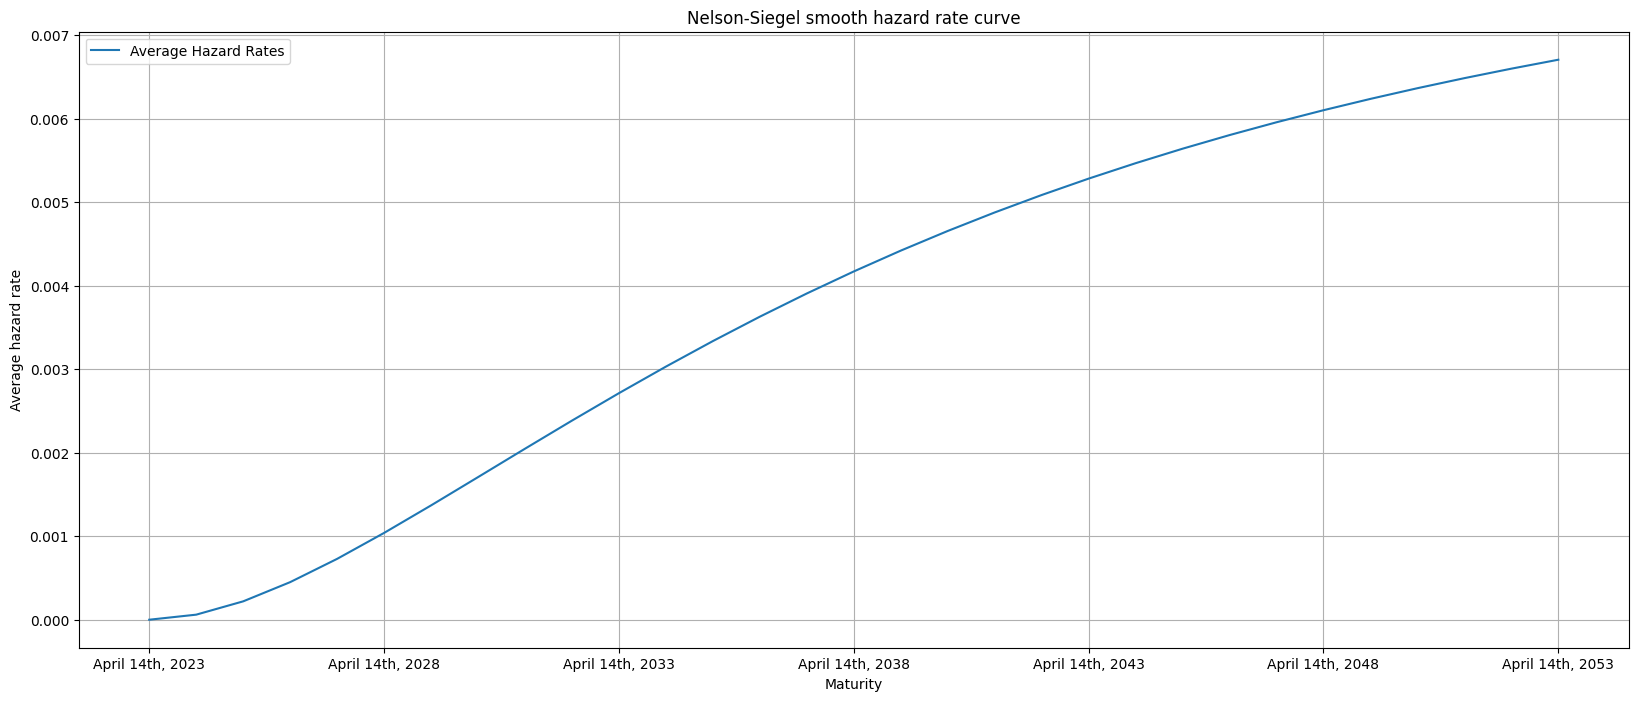

In [42]:
nelson_siegel_credit_curve_handle, nelson_siegel_surv_prob_df = create_smooth_credit_curve(optimal_params, calc_date, plot = True)

In [43]:
nelson_siegel_surv_prob_df

,Dates,Average Hazard Rates,Survival Probs
0,"April 14th, 2023",0.000000,1.000000
1,"April 14th, 2024",0.000061,0.999939
2,"April 14th, 2025",0.000220,0.999560
3,"April 14th, 2026",0.000450,0.998651
4,"April 14th, 2027",0.000729,0.997090
5,"April 14th, 2028",0.001039,0.994817
6,"April 14th, 2029",0.001369,0.991821
7,"April 14th, 2030",0.001707,0.988119
8,"April 14th, 2031",0.002048,0.983752
9,"April 14th, 2032",0.002384,0.978773


## d. Compute smooth model prices, yields and "edges"

Price all Verizon bonds on the calibrated credit curve and compute the corresponding yields.

Plot the model vs market yields (Y-axis) by time to maturity (X-axis).

Plot the edges in yield space (Y-axis) by time to maturity (X-axis).

In [44]:
def compute_smooth_model_price(df_verizon, nelson_siegel_credit_curve_handle, flat_yield_curve_handle):

    bond_recovery_rate = 0.4

    nelson_siegel_risky_bond_engine = ql.RiskyBondEngine(nelson_siegel_credit_curve_handle, bond_recovery_rate, flat_yield_curve_handle)

    df_verizon['market_price'] = df_verizon['mid_clean']
    df_verizon['market_yield'] = df_verizon['mid_yield']
    df_verizon['model_price'] = 0.0
    df_verizon['model_yield'] = 0.0
    df_verizon['edge'] = 0.0

    for index, row in df_verizon.iterrows():
        
        bond_object = create_bond_from_symbology(row)

        bond_object.setPricingEngine(nelson_siegel_risky_bond_engine)

        nelson_siegel_risky_bond_price = bond_object.cleanPrice()
        nelson_siegel_risky_bond_yield = bond_object.bondYield(nelson_siegel_risky_bond_price, \
            ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100

        df_verizon['model_price'][index] = nelson_siegel_risky_bond_price
        df_verizon['model_yield'][index] = nelson_siegel_risky_bond_yield

    df_verizon['edge'] = df_verizon['model_yield'] - df_verizon['market_yield']

    return df_verizon

In [45]:
def plot_yield_comparison(df_verizon):

    fig, ax = plt.subplots(figsize=(20, 8))

    plt.scatter(df_verizon['maturity'], df_verizon['model_yield'], color='orange', label='model yield')
    plt.scatter(df_verizon['maturity'], df_verizon['market_yield'], label='market yield')

    plt.xlabel('Maturity')
    plt.ylabel('Price')
    plt.title('Model vs Market Yields by Time to Maturity')

    plt.legend()
    plt.grid(True)

    plt.show()

In [46]:
def plot_edge(df_verizon):

    df_verizon.plot(x='maturity', y='edge',figsize = (20,8))

    plt.xlabel('Maturity')
    plt.ylabel('Edge')
    plt.title('Edges in Yield Space by Time to Maturity')
    plt.grid(True)

    plt.show()

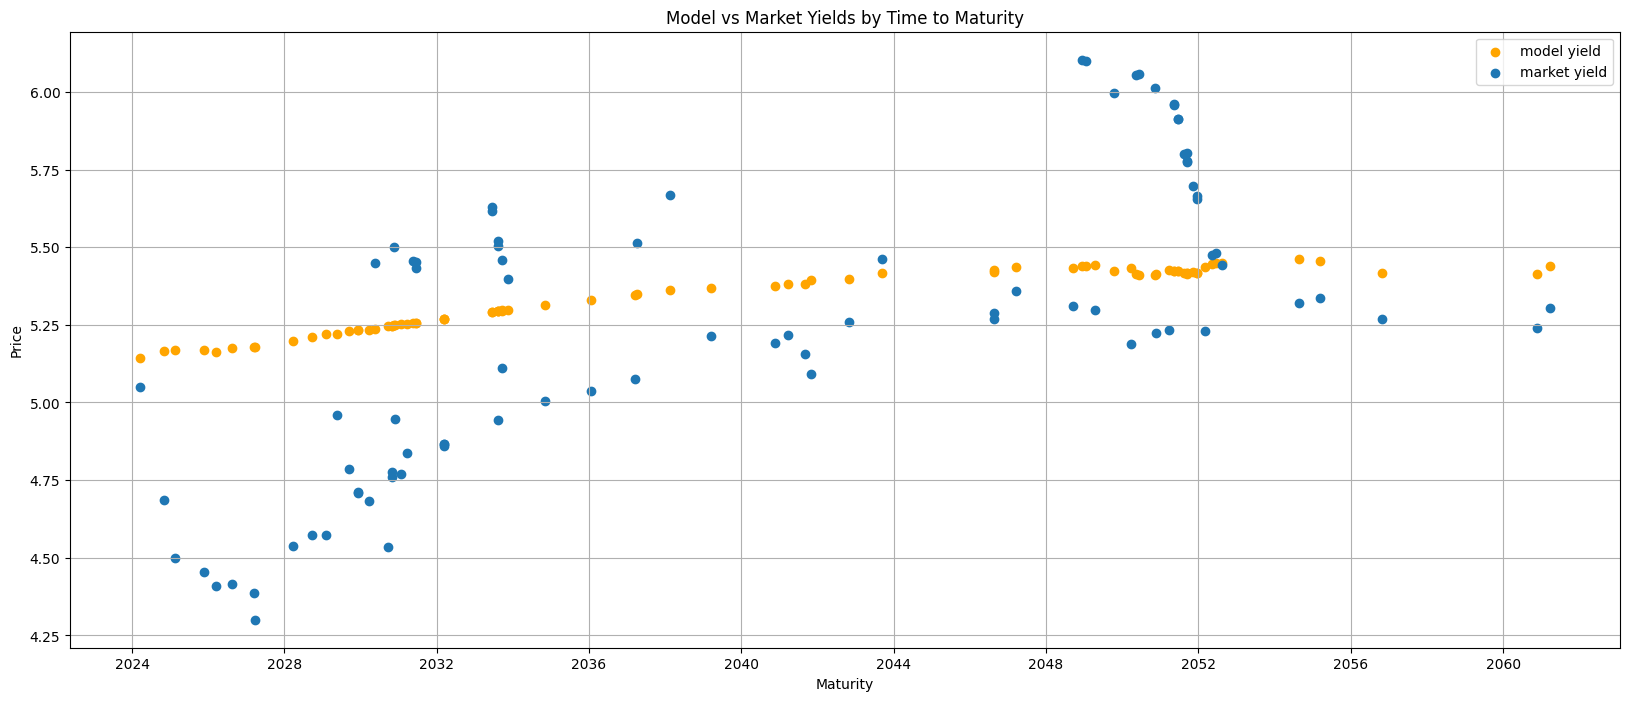

In [48]:
df_verizon = compute_smooth_model_price(df_verizon, nelson_siegel_credit_curve_handle, flat_yield_curve_handle)
plot_yield_comparison(df_verizon)

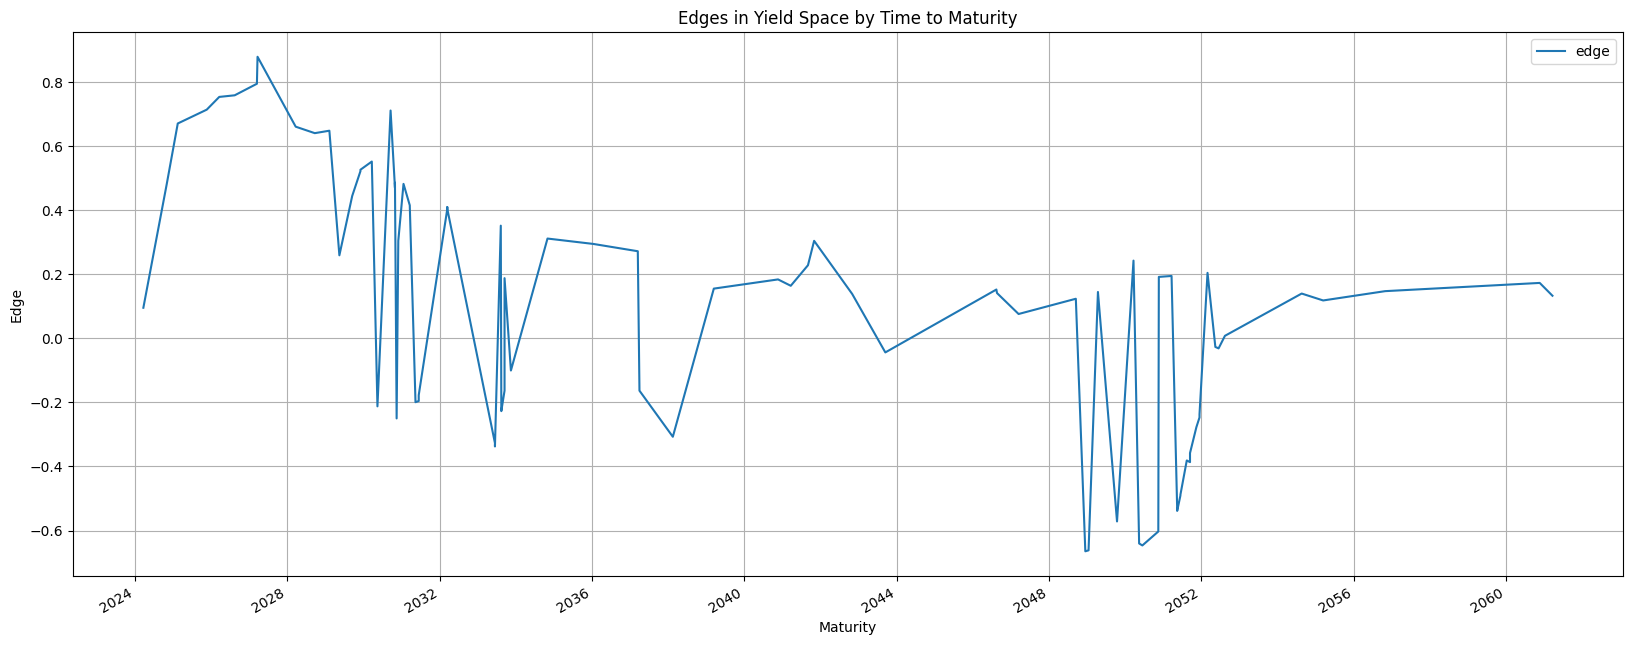

In [49]:
plot_edge(df_verizon)

# Problem 4: Pricing bonds in the Merton Structural Credit Model
## Follow Lecture 4, Section 2 "Structural Credit Default Models"

## a. Company balance sheet metrics & fair value of equity
- Assets of $125 MM
- Liabilities of $100 MM face value, consisting of one zero coupon bond.
- Bond maturity is at T = 5 years
- Asset volatility at 20% (log-normal annualized vol)
- Flat risk-free interest rates of 4%

Compute the company Leverage, "Book Value of Equity" and fair value of equity metrics.


In [84]:
import math
from scipy.stats import norm

def calculate_fair_value(assets, liabilities, bond_maturity, volatility, risk_free_rate):
    """
    Calculates the fair value of equity using the Merton model.

    Parameters:
        assets (float): Total assets of the company
        liabilities (float): Total liabilities of the company
        bond_maturity (float): Maturity of the company's zero coupon bond in years
        volatility (float): Volatility of the company's asset value (log-normal annualized vol)
        risk_free_rate (float): Risk-free interest rate

    Returns:
        float: Fair value of equity
    """
    d1 = (math.log(assets / liabilities) + (risk_free_rate + 0.5 * volatility**2) * bond_maturity) / (volatility * math.sqrt(bond_maturity))
    d2 = (math.log(assets / liabilities) + (risk_free_rate - 0.5 * volatility**2) * bond_maturity) / (volatility * math.sqrt(bond_maturity))

    fair_value_equity = assets * norm.cdf(d1) - liabilities * math.exp(-risk_free_rate * bond_maturity) * norm.cdf(d2)
    fair_value_liabilities = assets * norm.cdf(-d1) + liabilities * math.exp(-risk_free_rate * bond_maturity) * norm.cdf(d2)
    
    return d1, d2, fair_value_equity, fair_value_liabilities


In [87]:
assets = 125
liabilities = 100
maturity = 5
vol = 0.2
rf = 0.04

L = assets/liabilities
BVE = assets - liabilities

d1, d2, fair_value_equity, fair_value_liabilities = calculate_fair_value(assets, liabilities, maturity, vol, rf)

print(f'Leverage: {L}')
print(f'Book Value of Equity: {BVE} MM')
print(f'Fair Value of Equity: {round(fair_value_equity,2)} MM')


Leverage: 1.25
Book Value of Equity: 25 MM
Fair Value of Equity: 47.23 MM


## b. Risky Bond Valuation (Fair Value of Liabilities)

Compute the fair value of the risky bond.

In [88]:
print(f'Fair Value of Liabilities: {round(fair_value_liabilities,2)} MM')

Fair Value of Liabilities: 77.77 MM


## c. Flat yield, spread and hazard rate

Compute the following credit risk metrics:
- Distance to Default
- Default Probability
- Bond Yield
- Bond Credit Spread
- Flat Hazard Rate
- Expected Recovery on Default

Plot bond credit spreads as a function of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM.

In [168]:
distance_to_default = d2
default_prob = norm.cdf(-d2)
bond_yield = -np.log(fair_value_liabilities / liabilities) / maturity
bond_credit_spread = bond_yield - rf
flat_hazard_rate = -np.log(1-default_prob) / maturity
expected_recovery = 1 - norm.pdf(-d2) * np.exp(-rf * maturity) * (assets / liabilities)

print("Distance to Default: ", round(distance_to_default,4))
print("Default Probability: ", round(default_prob,4))
print("Bond Yield: ", round(bond_yield,4))
print("Bond Credit Spread: ", round(bond_credit_spread,4))
print("Flat Hazard Rate: ", round(flat_hazard_rate,4))
print("Expected Recovery on Default: ", round(expected_recovery,4))

Distance to Default:  0.7226
Default Probability:  0.235
Bond Yield:  0.0503
Bond Credit Spread:  0.0103
Flat Hazard Rate:  0.0536
Expected Recovery on Default:  0.6855


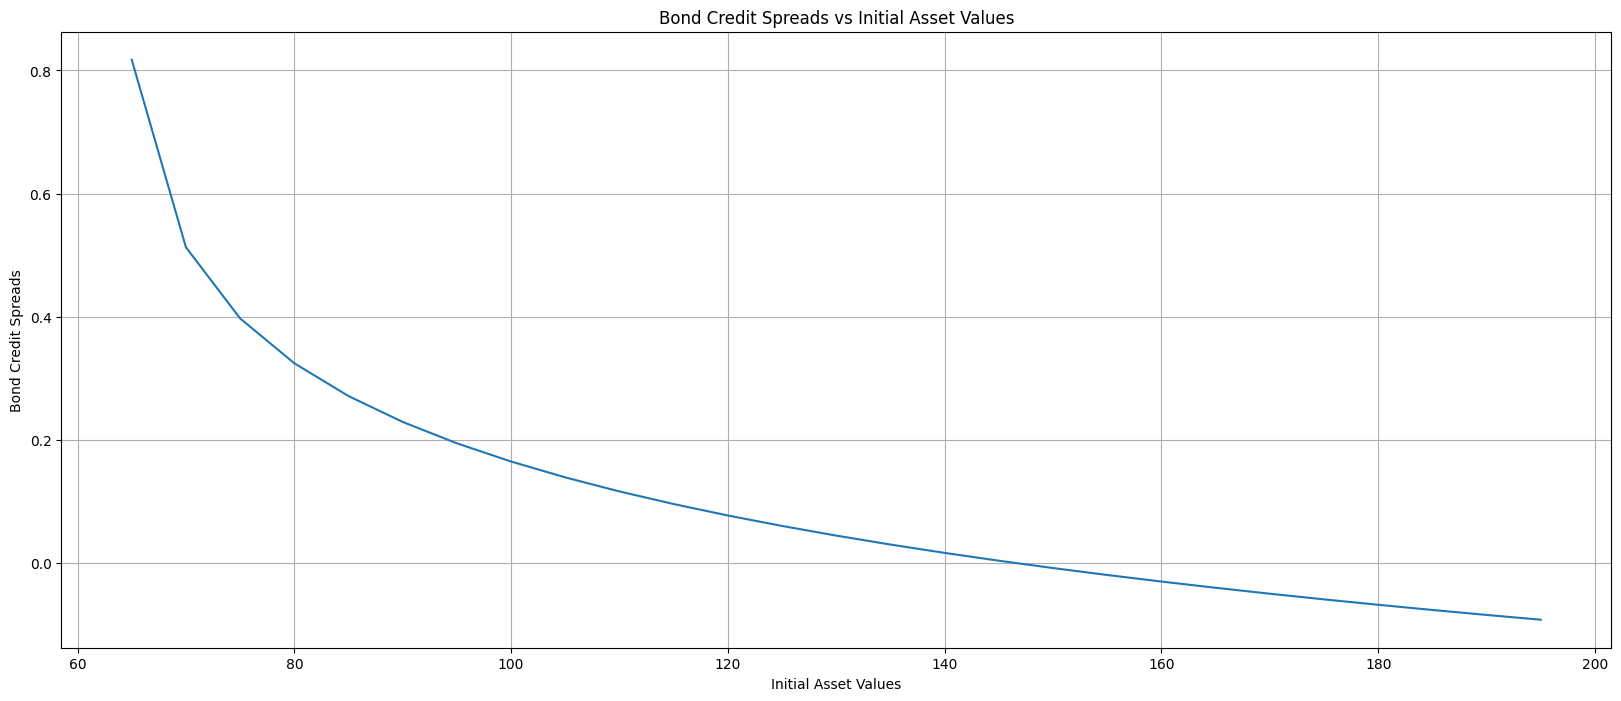

In [169]:
# Plot bond credit spreads as a function of initial Asset values
asset_values = np.arange(50, 200, 5)
credit_spreads = []

for asset in asset_values:
    bond_price = asset * norm.cdf(d1) - liabilities * np.exp(-rf * maturity) * norm.cdf(d2)
    yield_rate = -np.log(bond_price / liabilities) / maturity
    credit_spread = yield_rate - rf
    credit_spreads.append(credit_spread)

plt.figure(figsize=(20, 8))
plt.plot(asset_values, credit_spreads)
plt.xlabel('Initial Asset Values')
plt.ylabel('Bond Credit Spreads')
plt.title('Bond Credit Spreads vs Initial Asset Values')
plt.grid(True)
plt.show()

## d. Equity volatility

Compute the Equity Volatility.

What happens to the equity volatility if initial Assets value goes up/down (as of time 0)?

Plot Equity Volatilities of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM.

 

In [170]:
equity_volatility = norm.pdf(d1) * vol * (assets / fair_value_equity)
print("Equity Volatility: ", round(equity_volatility, 4))

Equity Volatility:  0.0203


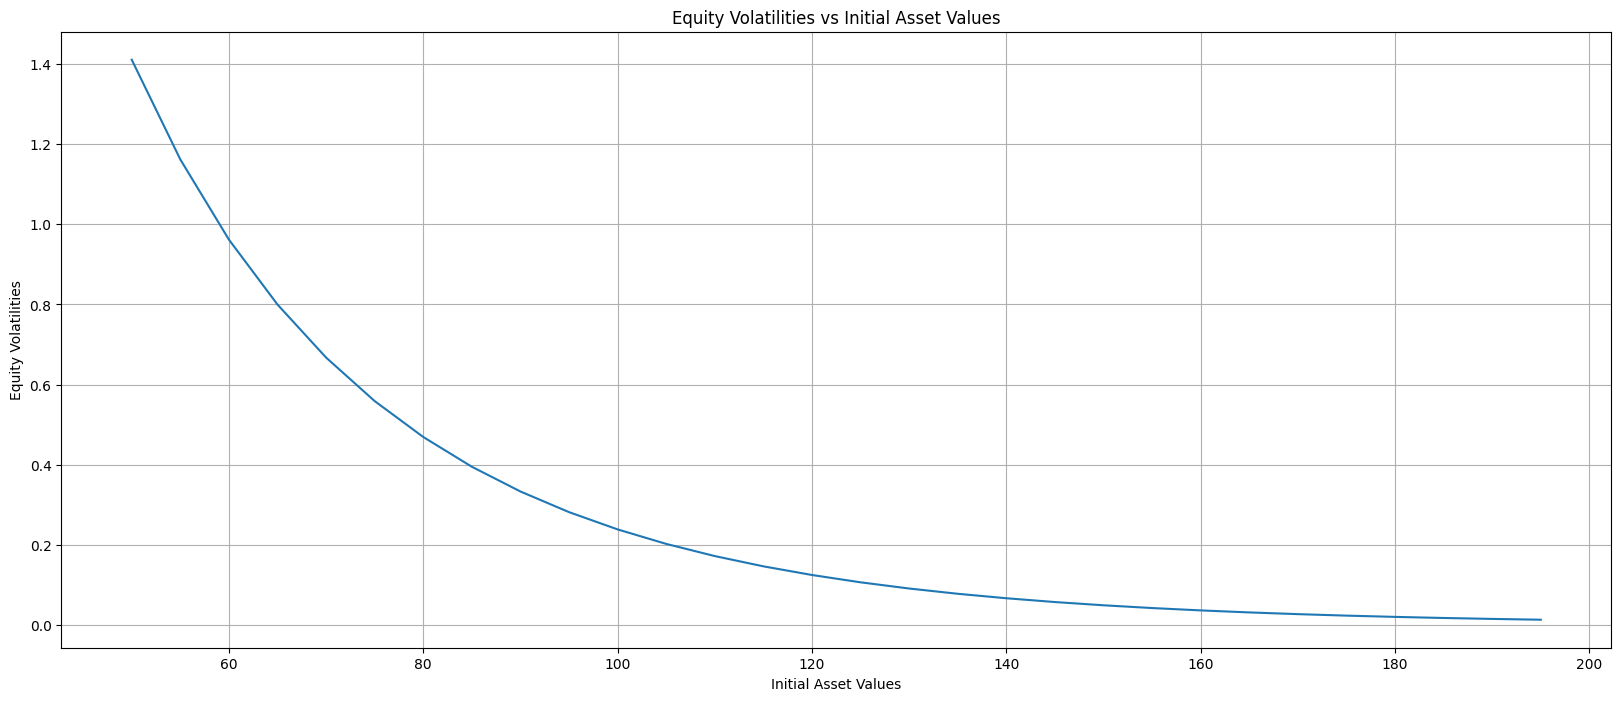

In [172]:
equity_volatilities = []

for asset in asset_values:
    d1 = (np.log(asset / liabilities) + (rf + 0.5 * vol ** 2) * maturity) / (vol * np.sqrt(maturity))
    d2 = d1 - vol * np.sqrt(maturity)
    equity_value = asset * norm.cdf(d1) - liabilities * np.exp(-rf * maturity) * norm.cdf(d2)
    equity_vol = norm.pdf(d1) * vol / (equity_value / asset)
    equity_volatilities.append(equity_vol)

plt.figure(figsize=(20, 8))
plt.plot(asset_values, equity_volatilities)
plt.xlabel('Initial Asset Values')
plt.ylabel('Equity Volatilities')
plt.title('Equity Volatilities vs Initial Asset Values')
plt.grid(True)
plt.show()